In [80]:
import pandas as pd
import numpy as np
import csv
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, f1_score, balanced_accuracy_score
from sklearn.model_selection import GridSearchCV, KFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE


# Read Emotion6 
my_data_Emotion6 = pd.read_csv("D:\RP_Databases\Emotion6\Emotion6\ground_truth.txt", sep='\t')
my_data_Emotion6["[image_filename]"] = my_data_Emotion6["[image_filename]"].apply(lambda x: str(x).split('/')[0])
my_data_Emotion6.columns = ["[image_filenames]","[valence]","[arousal]","anger","disgust","fear","joy","sadness","surprise", "neutral"]
my_data_Emotion6['Emotion'] = my_data_Emotion6[["anger","disgust","fear","joy","sadness","surprise", "neutral"]].idxmax(axis=1)
my_data_Emotion6 = my_data_Emotion6[['Emotion', '[valence]', '[arousal]']]
my_data_Emotion6.columns = ["Emotion", "Valence", "Arousal"]
#my_data_Emotion6 = my_data_Emotion6[ my_data_Emotion6['Emotion'] != "neutral"]

# Read IAPS
my_data_IAPS_va = pd.read_excel("D:\Libkuman-BRM-2007\Libkuman(2007)APP-B.xls", usecols='B, L, N',skiprows=[0,1])
my_data_IAPS_va.columns = ["IAPS", "Valence", "Arousal"]
my_data_IAPS_e = pd.read_excel("D:\Libkuman-BRM-2007\Libkuman(2007)APP-D.xls", skiprows=[0,1,2])
my_data_IAPS_e.columns = ["Description","IAPS","N","Happiness_M","Happiness_SD","Suprise_M","Surprise_SD","Sadness_M","Sadness_SD","Anger_M","Anger_SD","Disgust_M","Disgust_SD","Fear_M","Fear_SD" ]
my_data_IAPS_e = my_data_IAPS_e[["Description","IAPS","Happiness_M","Suprise_M","Sadness_M","Anger_M","Disgust_M","Fear_M"]]
my_data_IAPS_e.columns = ['Description', 'IAPS', 'joy', 'surprise','sadness', 'anger', 'disgust', 'fear' ]
my_data_IAPS_e['Emotion'] = my_data_IAPS_e[["joy","surprise","sadness","anger","disgust","fear"]].idxmax(axis=1)
my_data_IAPS_e = my_data_IAPS_e[['IAPS','Emotion']]

my_data_IAPS_va["IAPS"] = my_data_IAPS_va["IAPS"].astype(int)
my_data_IAPS_e["IAPS"] = my_data_IAPS_e["IAPS"].astype(int)

my_data_IAPS = pd.concat([my_data_IAPS_e, my_data_IAPS_va], axis=1)
my_data_IAPS = my_data_IAPS[['Emotion', 'Valence', 'Arousal']]

my_data_IAPS = my_data_IAPS.dropna()
my_data_Emotion6 = my_data_Emotion6.dropna()


# Combine two databases
my_data = pd.concat([my_data_IAPS, my_data_Emotion6])

df = shuffle(my_data)


# Prepare training data
X = np.array(df[["Valence", "Arousal"]])
y = np.array(df["Emotion"])

# counter = Counter(y)
# print(counter)

# Balance dataset
sm = SMOTE(random_state=42)
X, y = sm.fit_resample(X, y)

# counter = Counter(y)
# print(counter)


Counter({'joy': 1011, 'sadness': 1011, 'neutral': 1011, 'disgust': 1011, 'fear': 1011, 'anger': 1011, 'surprise': 1011})


In [59]:
from sklearn.neighbors import KNeighborsClassifier


In [60]:
from sklearn.naive_bayes import GaussianNB


In [66]:
# Number of random trials
NUM_TRIALS = 30

# Arrays to store scores
nested_scores_tree_mean = np.zeros(NUM_TRIALS)

nested_scores_knn_mean = np.zeros(NUM_TRIALS)

nested_scores_nb_mean = np.zeros(NUM_TRIALS)

nested_scores_dummy_mean = np.zeros(NUM_TRIALS)



param_grid_tree = [{
    'max_depth': [2, 4, 8, 16, 32, 64], 
    'min_samples_leaf': [2, 4, 8, 16]
}]

param_grid_knn = {
    'n_neighbors': [2, 5, 10, 15],                                   
    'algorithm': ['ball_tree', 'kd_tree', 'brute', 'auto'],          
    'metric': ['minkowski', 'euclidean', 'manhattan', 'chebyshev']
}

param_grid_nb = {'var_smoothing': np.logspace(0,-9, num=100)}



# Loop for each trial
for i in range(NUM_TRIALS):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
#     inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)
#     outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)
    
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=i)
    
    # Nested CV with parameter optimization
    
    
    clf_tree = GridSearchCV(DecisionTreeClassifier(), param_grid_tree, cv=inner_cv, scoring='accuracy', refit=True)
    nested_score_tree = cross_val_score(clf_tree, X=X, y=y, cv=outer_cv)
    
    clf_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=inner_cv, scoring='accuracy', refit = True)
    nested_score_knn = cross_val_score(clf_knn, X=X, y=y, cv=outer_cv)
    
    clf_nb = GridSearchCV(GaussianNB(), param_grid_nb, cv=inner_cv, scoring='accuracy', refit=True)
    nested_score_nb = cross_val_score(clf_nb, X=X, y=y, cv=outer_cv)
    
    clf_dummy = GridSearchCV(DummyClassifier(), param_grid ={'strategy': ['most_frequent']}, cv=inner_cv, scoring='accuracy', refit=True)
    nested_score_dummy = cross_val_score(clf_dummy, X=X, y=y, cv=outer_cv)
    
    
    nested_scores_tree_mean[i] = nested_score_tree.mean()
    
    nested_scores_knn_mean[i] = nested_score_knn.mean()
       
    nested_scores_nb_mean[i] = nested_score_nb.mean()
    
    nested_scores_dummy_mean[i] = nested_score_dummy.mean()


dummy classifier
0.13051668297032734
0.0019388659613421013
decision tree classifier
0.5861382883152663
0.005340719732542098
knn classifier
0.6098913577289332
0.003706164720726626
nb classifier
0.38573782715457866
0.001355991674516689


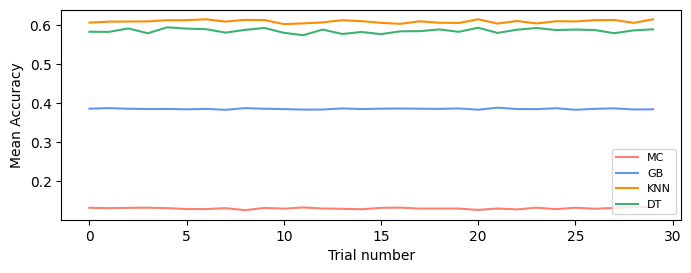

In [72]:
print("dummy classifier")
print(nested_scores_dummy_mean.mean())
print(nested_scores_dummy_mean.std())

print("decision tree classifier")
print(nested_scores_tree_mean.mean())
print(nested_scores_tree_mean.std())

print("knn classifier")
print(nested_scores_knn_mean.mean())
print(nested_scores_knn_mean.std())


print("nb classifier")
print(nested_scores_nb_mean.mean())
print(nested_scores_nb_mean.std())



# Plot scores on each trial for nested and non-nested CV
plt.figure(figsize=(8,6))
plt.subplot(211)

(nested_line_dummy,) = plt.plot(nested_scores_dummy_mean, color="salmon")
(nested_line_nb,) = plt.plot(nested_scores_nb_mean, color="cornflowerblue")
(nested_line_knn,) = plt.plot(nested_scores_knn_mean, color="darkorange")
(nested_line_tree,) = plt.plot(nested_scores_tree_mean, color="mediumseagreen")
plt.ylabel("Mean Accuracy")
plt.xlabel("Trial number")
plt.legend(
    [nested_line_dummy, nested_line_nb, nested_line_knn, nested_line_tree],
    ["MC", "GB", "KNN", "DT"],
    loc='lower right',
    prop = { "size": 8 },
)
plt.savefig('D:\performance.png')
plt.show()

In [83]:
# if p > alpha:
#   print("Fail to reject null hypotesis")
# else:
#   print("Reject null hypotesis")
from scipy import stats 

print(stats.ttest_ind(nested_scores_tree_mean, nested_scores_dummy_mean, equal_var = False))
print(stats.ttest_ind(nested_scores_knn_mean, nested_scores_dummy_mean, equal_var = False))
print(stats.ttest_ind(nested_scores_nb_mean, nested_scores_dummy_mean, equal_var = False))

print(stats.ttest_ind(nested_scores_knn_mean, nested_scores_tree_mean, equal_var = False))
print(stats.ttest_ind(nested_scores_tree_mean, nested_scores_nb_mean, equal_var = False))
print(stats.ttest_ind(nested_scores_knn_mean, nested_scores_nb_mean, equal_var = False))

Ttest_indResult(statistic=431.83695662052355, pvalue=2.610466372732082e-69)
Ttest_indResult(statistic=617.1899885949007, pvalue=7.291385548972115e-88)
Ttest_indResult(statistic=580.9015221424835, pvalue=1.274050818086854e-100)
Ttest_indResult(statistic=19.677024014001137, pvalue=1.1634673458092314e-25)
Ttest_indResult(statistic=195.85403470606246, pvalue=8.339170059556207e-52)
Ttest_indResult(statistic=305.8717259114873, pvalue=5.1785108795869374e-64)


In [82]:
import statsmodels.stats.multitest
from statsmodels.stats.multitest import multipletests


# Use Bonferroni correction to correct p values for multiple testing
pvals=[2.610466372732082e-69, 7.291385548972115e-88, 1.274050818086854e-100, 1.1634673458092314e-25, 8.339170059556207e-52, 5.1785108795869374e-64]

decision, adj_pvals, sidak_aplha, bonf_alpha = statsmodels.stats.multitest.multipletests(pvals=pvals, alpha=0.05, method='bonferroni')

adj_pvals


array([1.56627982e-068, 4.37483133e-087, 7.64430491e-100, 6.98080407e-025,
       5.00350204e-051, 3.10710653e-063])